### Regression for Count Data

In [1]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

##### 1. Load merged data

In [2]:
covid_final = pd.read_csv('covid_final.csv')
display(covid_final.head())

,location_key,date,inc_case,inc_death,population,inc_hosp,sni_covid19_vaccination,children,adult,elderly,new_persons_vaccinated,stringency_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Alabama,2021-01,0.21985,1.58540,-0.22656,1.37236,0.03200,-0.23121,-0.23664,-0.19831,-0.11133,0.49876,-1.14376,-1.22759,-1.00785,-0.70317,-0.39891,1.14349
1,Alabama,2021-02,-0.20186,1.19582,-0.22656,0.12667,0.47284,-0.23121,-0.23664,-0.19831,0.11210,0.63471,-1.02846,-0.88899,-1.00068,-0.66184,0.00911,0.92706
2,Alabama,2021-03,-0.29018,-0.13642,-0.22656,-0.26208,0.76117,-0.23121,-0.23664,-0.19831,0.38948,0.55474,0.24154,-0.18126,-0.53700,0.20080,0.40258,-0.31515
3,Alabama,2021-04,-0.34394,-0.34062,-0.22656,-0.30469,0.15088,-0.23121,-0.23664,-0.19831,0.26152,-0.10878,0.60873,0.28260,-0.24354,0.59766,0.50727,-0.86057
4,Alabama,2021-05,-0.31200,-0.36323,-0.22656,-0.31048,-0.62152,-0.23121,-0.23664,-0.19831,-0.20304,-0.43897,0.49524,0.79429,-0.13035,0.70267,0.40778,-0.82227


##### 2. Explore the distribution of inc_case

In [3]:
print(covid_final['inc_case'].dropna().astype(int).head(1000).to_list())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 16, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 8, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

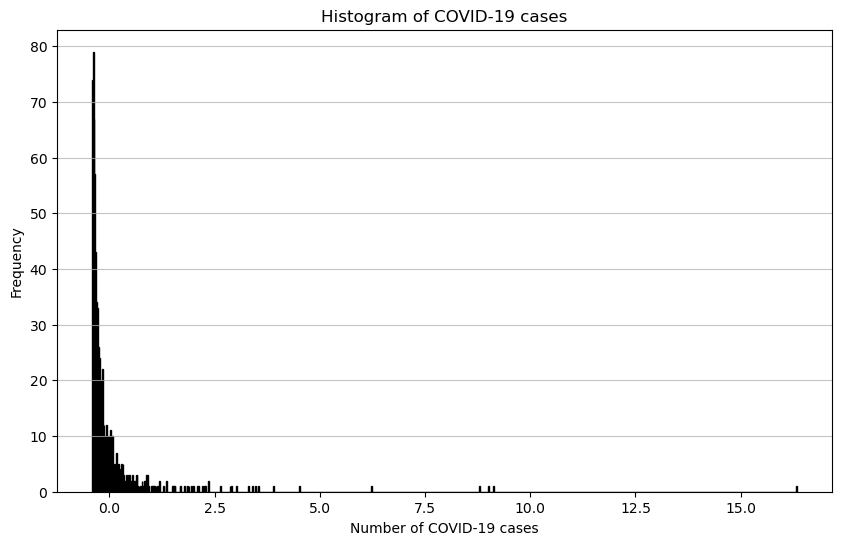

In [4]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(covid_final['inc_case'], bins=1000, color='skyblue', edgecolor='black')
plt.title('Histogram of COVID-19 cases')
plt.xlabel('Number of COVID-19 cases')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

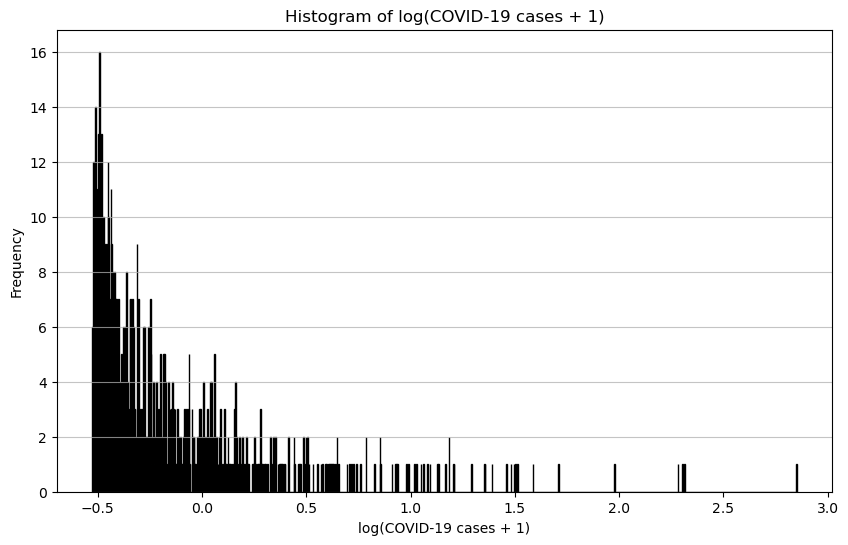

In [5]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(np.log(covid_final['inc_case']+1), bins=1000, color='skyblue', edgecolor='black')
plt.title('Histogram of log(COVID-19 cases + 1)')
plt.xlabel('log(COVID-19 cases + 1)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [6]:
X = covid_final[['sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index', 'inc_death',
                     'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline',
                     'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                     'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline',
                     'inc_hosp', 'inc_case', 'location_key', 'date']]
X_cleaned = X.dropna(axis=0, how='any')

y_cleaned = X_cleaned['inc_case']
y_log_cleaned = np.log(X_cleaned['inc_case']+1)
X_cleaned = X_cleaned.drop(columns=['inc_case'])

In [7]:
X_cleaned['date'] = pd.to_datetime(covid_final['date'], format='%Y-%m')
X_encoded = pd.get_dummies(X_cleaned, columns=['location_key'], drop_first=True).astype(int)

In [8]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_encoded)

# Apply transform to both the training set and the test set
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded), columns=X_encoded.columns, index=X_encoded.index)

In [9]:
X_encoded_with_const = sm.add_constant(X_train_scaled)

#### Linear Regression

In [10]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.OLS(y_cleaned, X_encoded_with_const ).fit()

# Displaying the regression results
print(model.summary())

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_97247/532582492.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                            OLS Regression Results                            
Dep. Variable:               inc_case   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     26.05
Date:                Sun, 24 Mar 2024   Prob (F-statistic):          1.93e-149
Time:                        18:14:32   Log-Likelihood:                -736.82
No. Observations:                 850   AIC:                             1598.
Df Residuals:                     788   BIC:                             1892.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

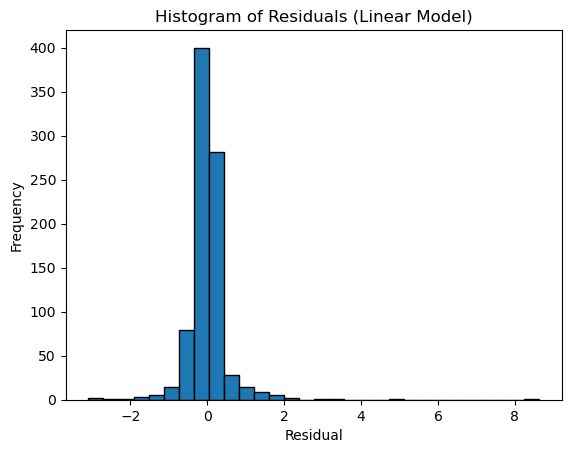

In [11]:
# Plotting histogram of residuals
residuals = model.resid
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Linear Model)')
plt.show()

In [12]:
# extract and plot regression coefficients 
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

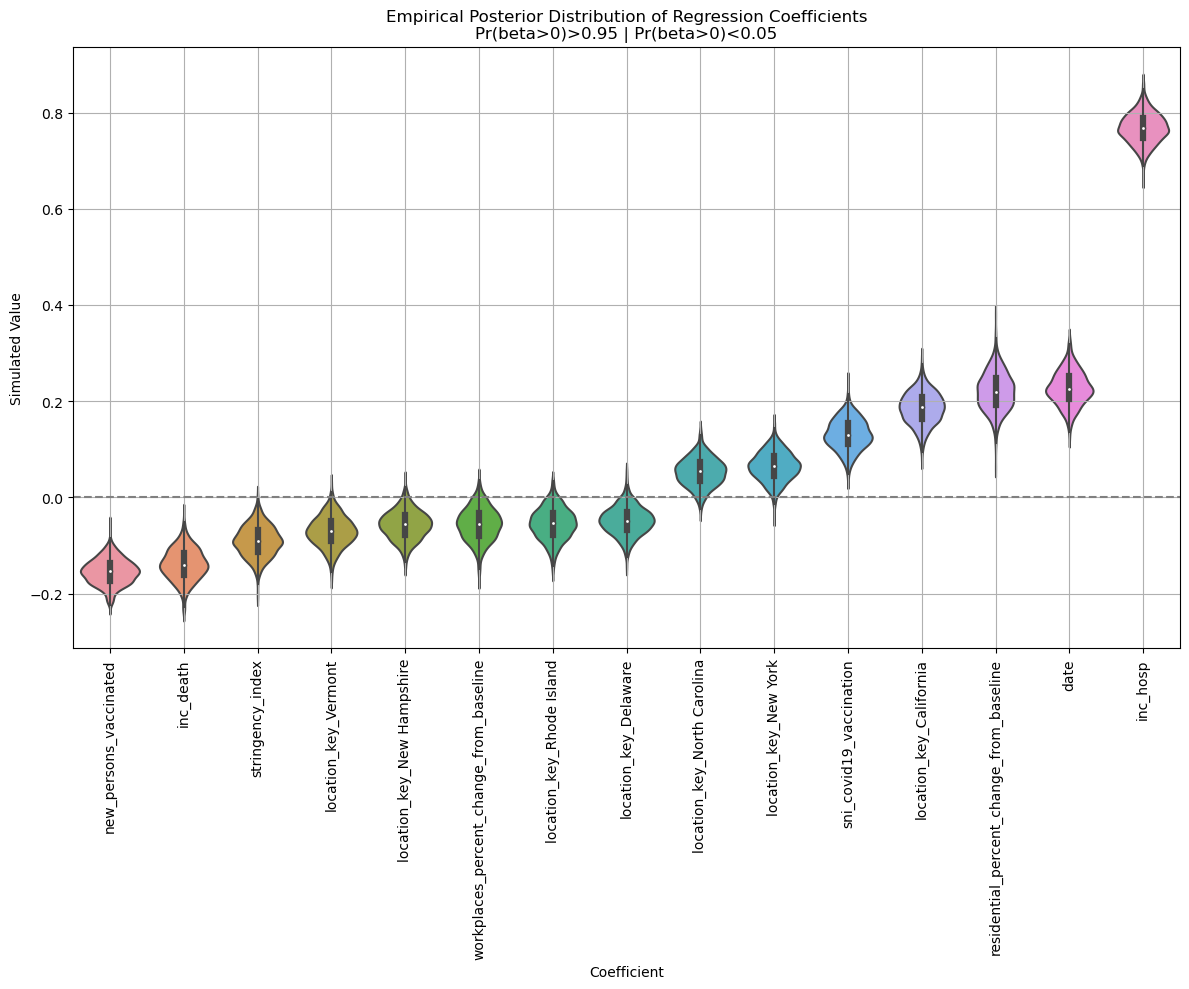

In [13]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')

# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [14]:
# Initialize an array to store predictions from each simulation
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [15]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.dot(X_encoded_with_const, beta_simulation)
    predicted_counts[i] = np.random.normal(predicted_rate,np.sqrt(model.scale))

In [16]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)


# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

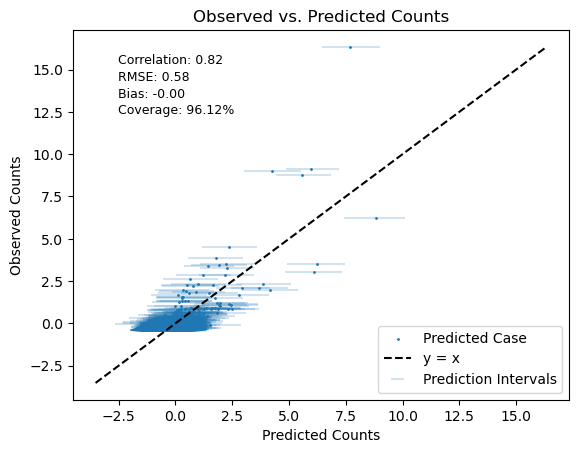

In [17]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Predicted Case')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Counts')
plt.xlabel('Predicted Counts')
plt.ylabel('Observed Counts')
plt.show()


#### Log-linear Regression

In [18]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.OLS(y_log_cleaned, X_encoded_with_const ).fit()

# Displaying the regression results
print(model.summary())

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_97247/598896821.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                            OLS Regression Results                            
Dep. Variable:               inc_case   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     30.63
Date:                Sun, 24 Mar 2024   Prob (F-statistic):          8.77e-168
Time:                        18:14:33   Log-Likelihood:                -3.2579
No. Observations:                 850   AIC:                             130.5
Df Residuals:                     788   BIC:                             424.7
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

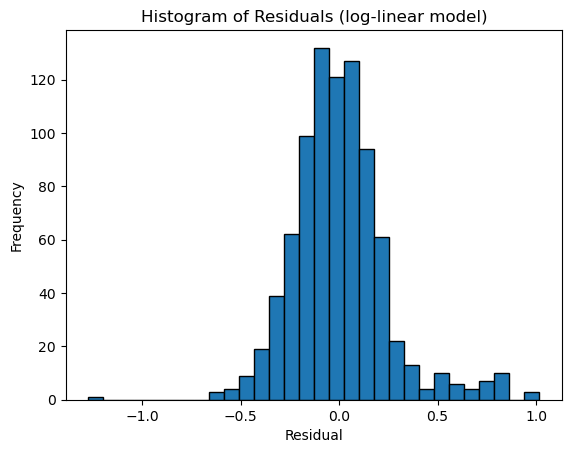

In [19]:
# Plotting histogram of residuals
residuals = model.resid
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (log-linear model)')
plt.show()

In [20]:
# extract and plot regression coefficients 
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

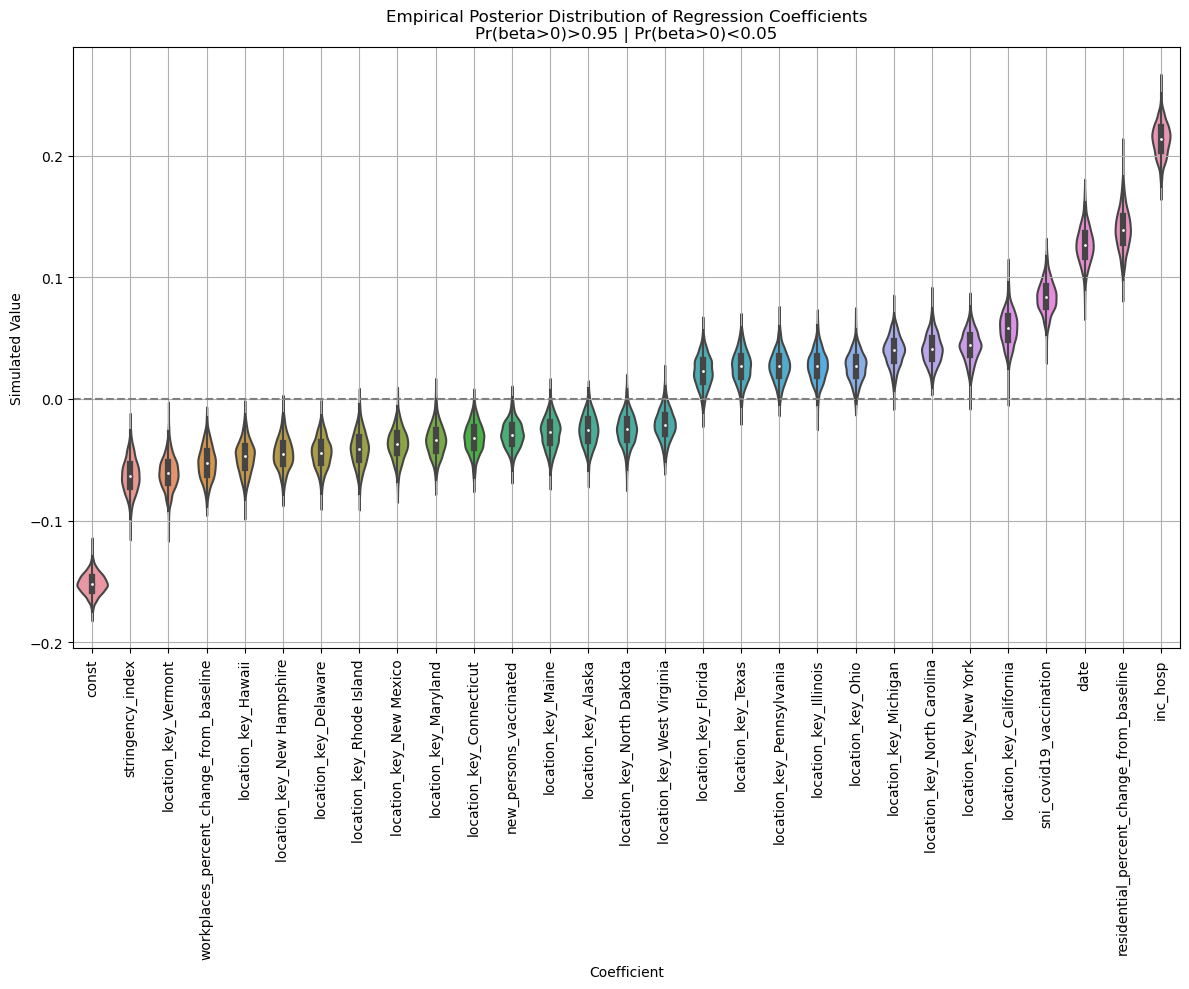

In [21]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')


# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [22]:
# Initialize an array to store predictions from each simulation
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [23]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_log_rate = np.dot(X_encoded_with_const, beta_simulation)
    # Simulate from the posterior-predictive distirbution 
    # If we do nothing to `rate`, this will spit out an error because some rates will be `negativ
    predicted_counts[i] = np.exp(np.random.normal(predicted_log_rate,np.sqrt(model.scale)))

In [24]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

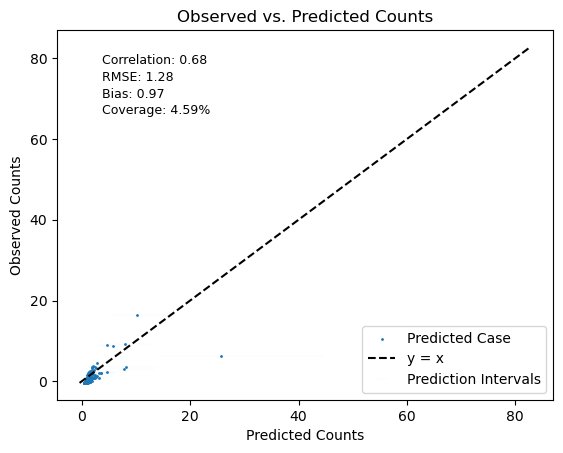

In [25]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Predicted Case')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.01, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Counts')
plt.xlabel('Predicted Counts')
plt.ylabel('Observed Counts')
plt.show()


#### Poisson Regression

In [26]:
from statsmodels.api import GLM, Poisson

In [27]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.GLM(y_cleaned, X_encoded_with_const, family=sm.families.Poisson()).fit()

# Displaying the regression results
print(model.summary())

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_97247/453724424.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/opt/anaconda3/envs/cssci/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/opt/anaconda3/envs/cssci/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


ValueError: NaN, inf or invalid value detected in weights, estimation infeasible.

In [ ]:
# extract and plot regression coefficients 
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

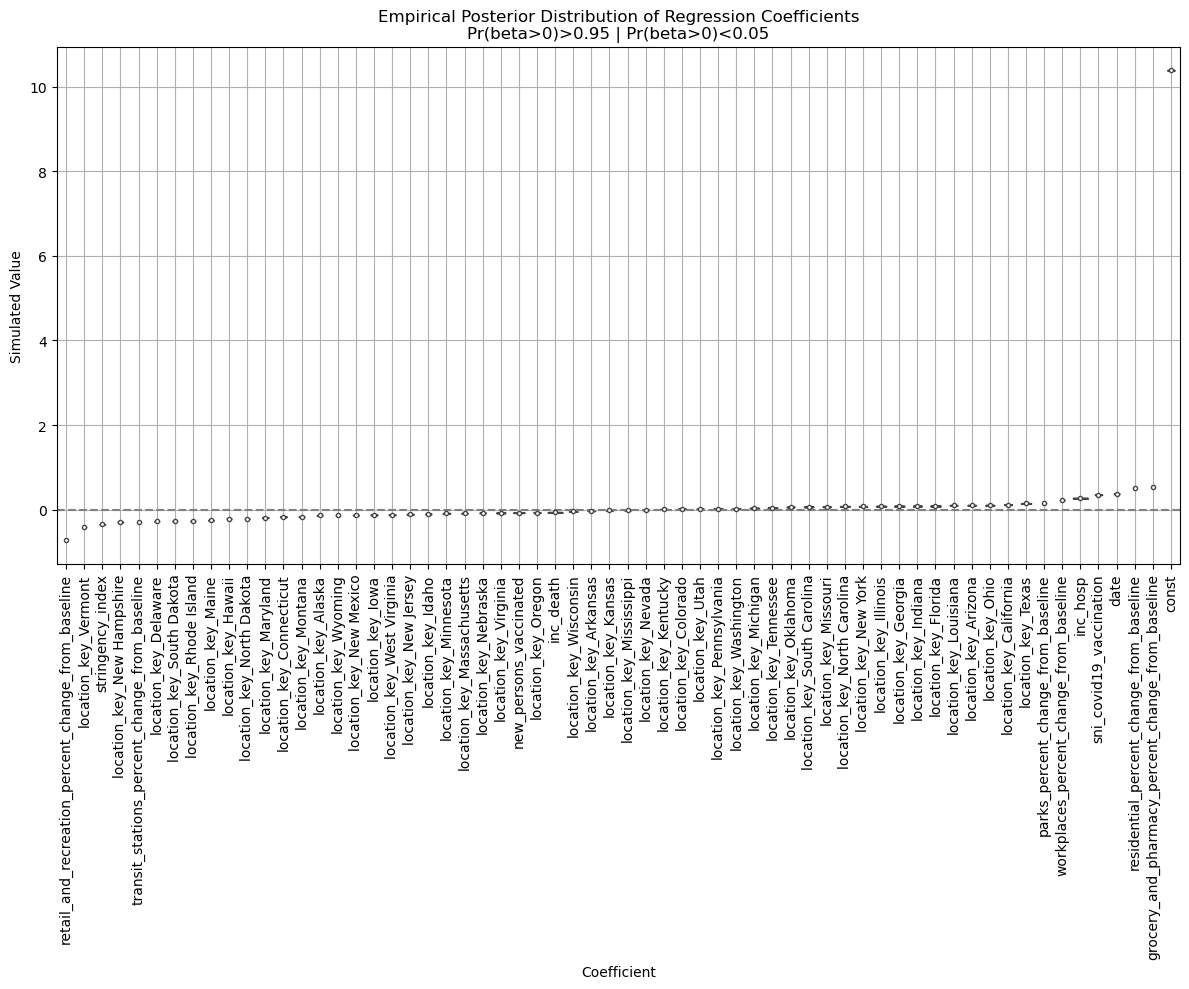

In [ ]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')


# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [ ]:
# Initialize an array to store predictions from each simulation
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

In [ ]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.exp(np.dot(X_encoded_with_const, beta_simulation))
    predicted_counts[i] = np.random.poisson(predicted_rate)

In [ ]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)


# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

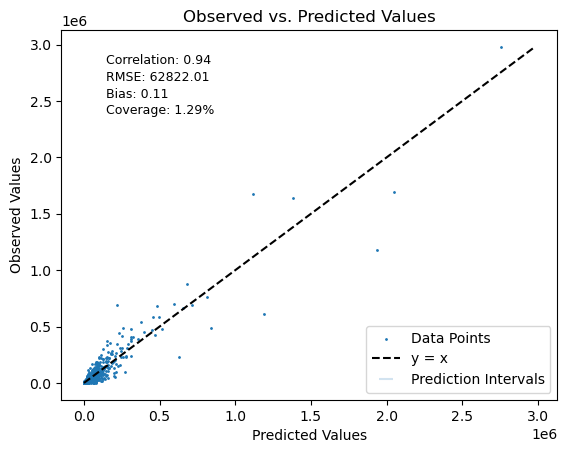

In [ ]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()
